In [5]:
from customProphet import *
from prophet import Prophet
import matplotlib.pyplot as plt
import psutil
import time
import pandas as pd
plt.style.use('ggplot')

df = pd.read_csv('peyton_manning.csv')

# Memory Tracker

def get_current_process_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss  # Returning Resident Set Size (physical memory usage)

def run_function_and_get_memory(target_function, num_runs=5, sleep_time=1):
    memory_usages = []

    for _ in range(num_runs):
        # Run the target function
        target_function()
        
        # Wait for a bit to ensure the process memory usage is stable
        time.sleep(sleep_time)
        
        # Get the memory usage of the current process
        memory_usage = get_current_process_memory_usage()
        
        # Add to the list if memory usage is found
        if memory_usage:
            memory_usages.append(memory_usage)
        
    if memory_usages:
        memory_usage = np.array(memory_usages)
        m = memory_usage.mean()
        std = memory_usage.std()
        return m, std
    else:
        return None

/Users/adly/Desktop/customProphet/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Gradient sanity check

In [7]:
def loss(model, params):
    k, m, delta, beta = extract_params(params)
    
    A = (model.t_scaled[:, None] > model.change_points) * 1
    gamma = -model.change_points * delta
    g = (k + det_dot(A, delta)) * model.t_scaled + (m + det_dot(A, gamma))

    period = 365.25 / model.scale_period
    x = fourier_components(model.t_scaled, period, 10)
    s = np.dot(x, beta)

    y_pred = g + s
    y_true = model.normalized_y
    r = y_true - y_pred
    
    return np.sum(r**2) / (2 * model.sigma_obs**2) + np.sum(beta**2) / 2*model.sigma**2 \
        + np.sum(np.abs(delta)) / model.tau + k**2 / (2 * model.sigma_k**2) \
        + m**2 / (2 * model.sigma_m**2)
        
def gradient(model, params):
    k, m, delta, beta = extract_params(params)
    
    A = (model.t_scaled[:, None] > model.change_points) * 1
    gamma = -model.change_points * delta
    g = (k + np.dot(A, delta)) * model.t_scaled + (m + np.dot(A, gamma))

    period = 365.25 / model.scale_period
    x = fourier_components(model.t_scaled, period, 10)
    s = np.dot(x, beta)

    y_pred = g + s
    y_true = model.normalized_y
    r = y_true - y_pred
    
    dk = np.array([-np.sum(r * model.t_scaled) / model.sigma_obs**2 + k / model.sigma_k**2])
    dm = np.array([-np.sum(r) / model.sigma_obs**2 + m / model.sigma_m**2])
    ddelta = -np.sum(r[:, None] * (model.t_scaled[:, None] - model.change_points) * A, axis=0) / model.sigma_obs**2 + np.sign(delta) / model.tau
    dbeta = -np.dot(r, x) / model.sigma_obs**2 + beta / model.sigma**2
    
    return np.concatenate([dk, dm, ddelta, dbeta])    

def numerical_gradient(loss, model, params, epsilon=1e-6):
    num_grad = np.zeros_like(params)
    for i in range(len(params)):
        params_perturbed = params.copy()
        params_perturbed[i] += epsilon
        loss_plus_epsilon = loss(model, params_perturbed)
        
        params_perturbed[i] -= 2 * epsilon
        loss_minus_epsilon = loss(model, params_perturbed)
        
        num_grad[i] = (loss_plus_epsilon - loss_minus_epsilon) / (2 * epsilon)
    
    return num_grad


## instantiate & initialize a model
model = CustomProphet()
model.y = df['y'].values
if df['ds'].dtype != 'datetime64[ns]':
    model.ds = pd.to_datetime(df['ds'])
else:
    model.ds = df['ds']

model.t_scaled = np.array((model.ds - model.ds.min()) / (model.ds.max() - model.ds.min()))
model.T = df.shape[0]

model.scale_period = (model.ds.max() - model.ds.min()).days
model._normalize_y()
model._generate_change_points()

params = np.ones((47,))
# Calculate numerical gradient
num_grad = numerical_gradient(loss, model, params)

# Calculate analytical gradient
anl_grad = gradient(model, params)

are_close = np.allclose(anl_grad, num_grad)

# If you need to inspect the differences
differences = anl_grad - num_grad

# Print results
print("Are the gradients approximately equal?", are_close)
print("Differences:", differences)


Are the gradients approximately equal? False
Differences: [ 4.50988300e-05  1.32811628e-03 -1.49039156e-03 -1.25865708e-03
 -1.02356169e-03 -5.77490311e-04  5.56029379e-04 -2.83353357e-03
 -3.49436188e-04 -9.54244286e-04  2.70365272e-05 -3.07380920e-04
 -4.53451648e-04 -2.50130473e-03 -5.40616806e-04 -2.46352446e-03
 -2.28496874e-03 -1.79489399e-03  8.46758485e-06 -2.02381855e-03
 -1.18158525e-03 -7.58490176e-04  1.07815606e-04 -2.84619787e-03
 -2.88569636e-03  2.68313044e-04 -1.32662460e-03 -9.99885523e+01
 -9.99886903e+01 -9.99880384e+01 -9.99897965e+01 -9.99903565e+01
 -9.99913926e+01 -9.99903939e+01 -9.99889168e+01 -9.99905102e+01
 -9.99913455e+01 -9.99906536e+01 -9.99895771e+01 -9.99887113e+01
 -9.99885388e+01 -9.99894653e+01 -9.99900205e+01 -9.99907979e+01
 -9.99897269e+01 -9.99886290e+01 -9.99899903e+01]


$\displaystyle g(t_i) = (k + a(t_i)\delta)t_i + (m + a(t_i)\gamma)\\
\frac{\partial g(t_i)}{\partial \delta} = t_ia(t_i) - \text{changepoints}\ a(t_i)\\
s(t_i) = \sum a_n \cos(\frac{2\pi t_i n}{P}) + b_n \sin(\frac{2\pi t_i n}{P}) = X(t_i) \beta\\
\frac{\partial s(t_i)}{\partial \beta} = X(t_i) \\
\mathcal{L}(k, m, \delta, \beta) = \frac{1}{2\sigma_{obs}^{2}} \sum_{i=1}^{T} \left[y_i - (g(t_i) + s(t_i))\right]^2 + \frac{1}{\tau}\sum |\delta_i| + \frac{1}{2\sigma^2}\sum \beta_i^2 + \frac{k^2}{2\sigma_k^2} + \frac{m^2}{2\sigma_m^2} \\ - \frac{1}{\sigma_{obs}^2} \sum [r_i t_i a(t_i)] + \frac{1}{\tau} \text{sgn} \ \delta$

## Finite Differences Peyton Manning

In [9]:
x = fourier_components(model.t_scaled, 365.25 / model.scale_period, 10)
x.shape

(2905, 20)

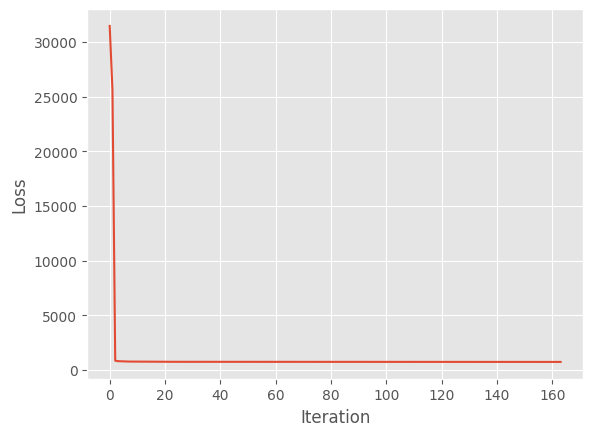

In [6]:
model = CustomProphet()
model.fit(df)

# Plot the loss over iterations
plt.plot(model.loss_over_iterations)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

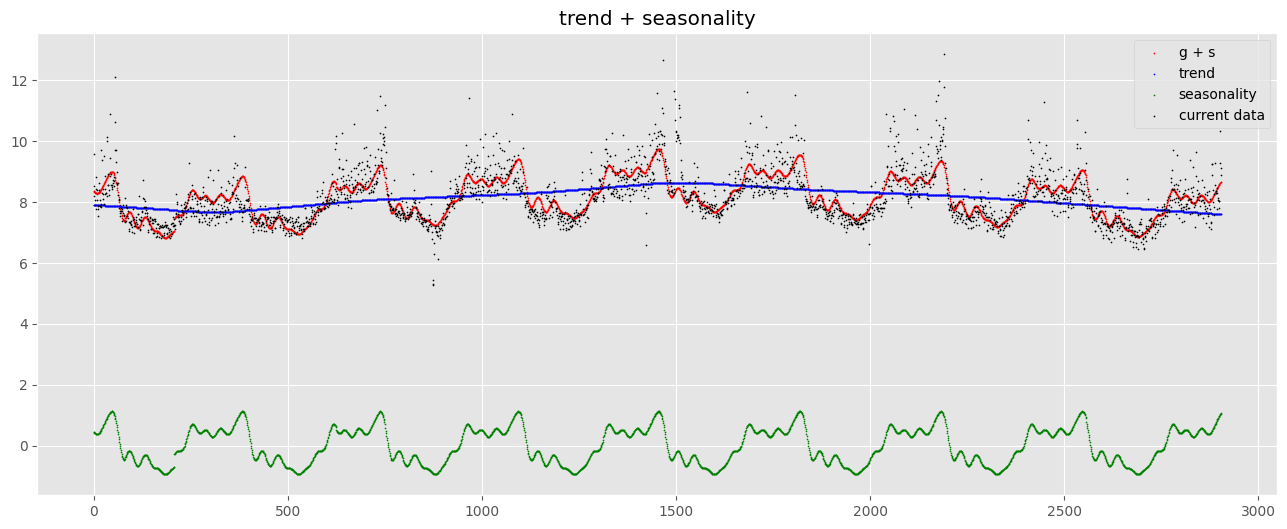

In [7]:
opt_params = model.get_parameters()
k, m, delta, beta = extract_params(opt_params)

# trend component
A = (model.t_scaled[:, None] > model.change_points) * 1
gamma = -model.change_points * delta
g = ((k + np.dot(A, delta)) * model.t_scaled + (m + np.dot(A, gamma))) * model.y_absmax
#g = ((k + det_dot(A, delta)) * model.t_scaled + (m + det_dot(A, gamma))) * model.y_absmax

x = fourier_components(model.t_scaled, 365.25 / model.scale_period, 10)
s = det_dot(x, beta) * model.y_absmax

plt.figure(figsize=(16, 6))
plt.title('trend + seasonality')
plt.scatter(np.arange(df.shape[0]), g+s, s=0.5, label='g + s', color='red')
plt.scatter(np.arange(df.shape[0]), g, s=0.5, label='trend', color='blue')
plt.scatter(np.arange(df.shape[0]), s, s=0.5, label='seasonality', color='green')
plt.scatter(np.arange(df.shape[0]), model.y, s=0.5, label='current data', color='black')
plt.legend()
plt.show()

In [8]:
model.opt, delta

(  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 731.0407330844004
         x: [-1.772e-01  6.155e-01 ...  3.719e-04 -5.898e-03]
       nit: 164
       jac: [-8.764e+00 -3.709e+01 ... -6.615e+00  1.291e+01]
      nfev: 11568
      njev: 241
  hess_inv: <47x47 LbfgsInvHessProduct with dtype=float64>,
 array([-1.68662096e-04,  1.67579603e-03,  1.47323706e-01,  2.81057188e-01,
        -6.12278489e-10,  2.03984273e-04, -3.71772420e-02, -9.77737614e-02,
        -1.65389638e-05, -8.37735521e-05,  1.30390664e-03,  5.93133353e-02,
         5.43600034e-02,  6.27352304e-05, -2.16932913e-05, -2.23185022e-01,
        -1.93572385e-01,  2.99068025e-04, -4.79561546e-04,  6.06610645e-02,
        -1.08125242e-03, -4.71484806e-04, -1.83109929e-03, -4.75121076e-02,
        -3.30384842e-02]))

## Analytic Gradient Peyton Manning

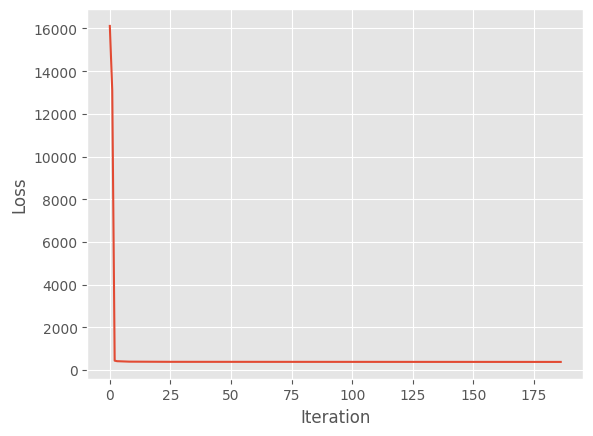

In [16]:
model = CustomProphet()
model.fit(df, analytic=True)

# Plot the loss over iterations
plt.plot(model.loss_over_iterations)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

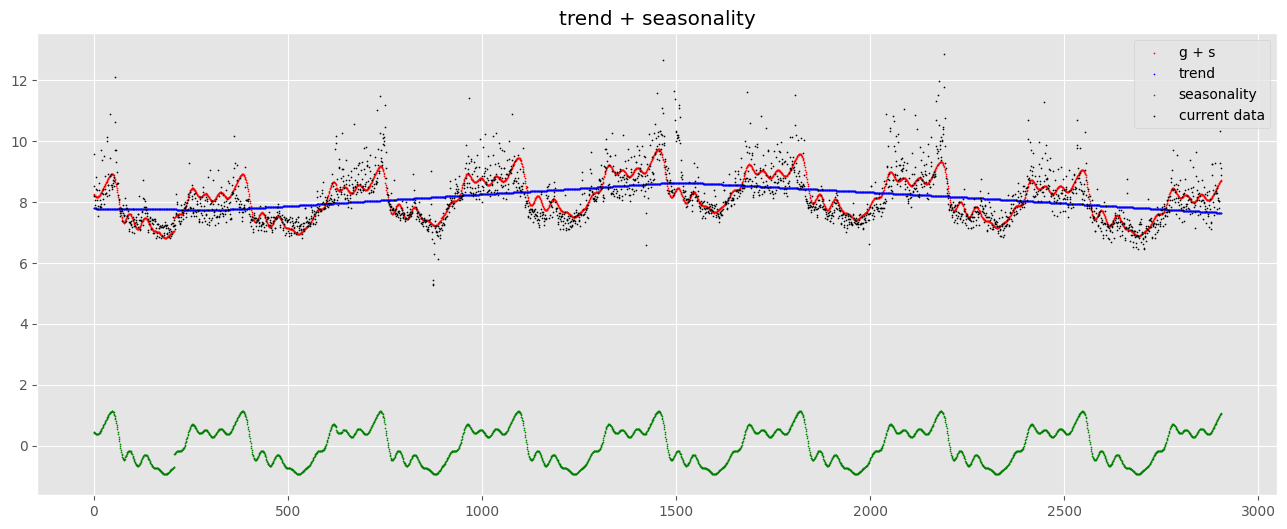

In [17]:
opt_params = model.get_parameters()
k, m, delta, beta = extract_params(opt_params)

# trend component
A = (model.t_scaled[:, None] > model.change_points) * 1
gamma = -model.change_points * delta
g = ((k + det_dot(A, delta)) * model.t_scaled + (m + det_dot(A, gamma))) * model.y_absmax

x = fourier_components(model.t_scaled, 365.25 / model.scale_period, 10)
s = det_dot(x, beta) * model.y_absmax

plt.figure(figsize=(16, 6))
plt.title('trend + seasonality')
plt.scatter(np.arange(df.shape[0]), g+s, s=0.5, label='g + s', color='red')
plt.scatter(np.arange(df.shape[0]), g, s=0.5, label='trend', color='blue')
plt.scatter(np.arange(df.shape[0]), s, s=0.5, label='seasonality', color='green')
plt.scatter(np.arange(df.shape[0]), model.y, s=0.5, label='current data', color='black')
plt.legend()
plt.show()

In [11]:
model.opt, delta

(  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 58.20529105764432
         x: [ 1.194e-01  5.978e-01 ...  5.998e-04 -5.881e-03]
       nit: 126
       jac: [ 9.797e+00 -2.412e+00 ...  3.182e+00 -1.303e+00]
      nfev: 213
      njev: 213
  hess_inv: <47x47 LbfgsInvHessProduct with dtype=float64>,
 array([ 4.85091961e-05,  4.11996164e-05, -1.26044431e-05,  4.94868750e-06,
        -7.19247456e-06, -5.45953893e-06,  4.05056934e-05, -1.76872375e-07,
        -9.94757471e-05, -2.09331999e-05, -1.01471068e-04, -2.67948898e-06,
        -1.12178046e-04, -9.44489221e-03, -2.98161347e-02, -5.03040106e-02,
        -5.40357385e-02, -4.57722753e-02, -3.22770388e-02, -1.66370667e-02,
        -6.40562866e-03,  2.62344552e-10, -1.98271524e-04, -6.14341674e-05,
        -1.04080878e-06]))

## Objective + Gradient Combined Peyton Manning

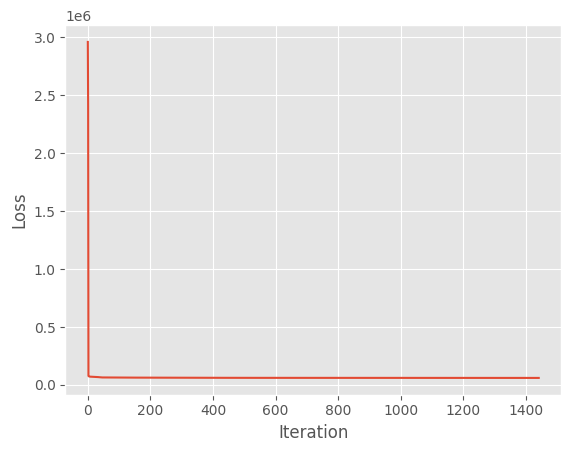

In [18]:
model = CustomProphet()
model.fit(df, use_combined=True)

# Plot the loss over iterations
plt.plot(model.loss_over_iterations)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

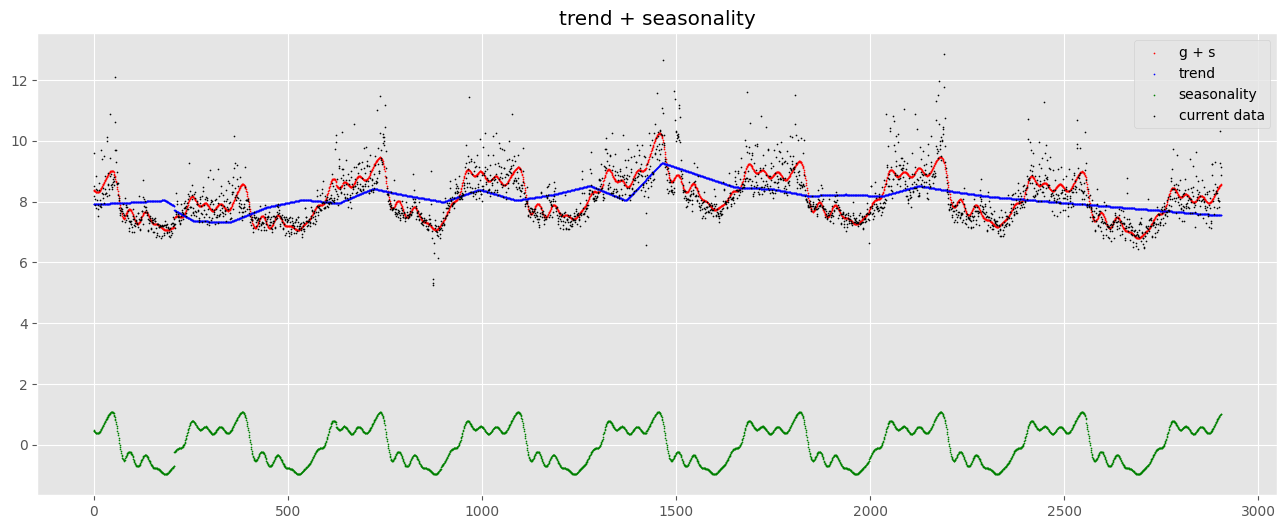

In [19]:
opt_params = model.get_parameters()
k, m, delta, beta = extract_params(opt_params)

# trend component
A = (model.t_scaled[:, None] > model.change_points) * 1
gamma = -model.change_points * delta
g = ((k + np.dot(A, delta)) * model.t_scaled + (m + np.dot(A, gamma))) * model.y_absmax
#g = ((k + det_dot(A, delta)) * model.t_scaled + (m + det_dot(A, gamma))) * model.y_absmax

x = fourier_components(model.t_scaled, 365.25 / model.scale_period, 10)
s = det_dot(x, beta) * model.y_absmax

plt.figure(figsize=(16, 6))
plt.title('trend + seasonality')
plt.scatter(np.arange(df.shape[0]), g+s, s=0.5, label='g + s', color='red')
plt.scatter(np.arange(df.shape[0]), g, s=0.5, label='trend', color='blue')
plt.scatter(np.arange(df.shape[0]), s, s=0.5, label='seasonality', color='green')
plt.scatter(np.arange(df.shape[0]), model.y, s=0.5, label='current data', color='black')
plt.legend()
plt.show()

In [20]:
model.opt, delta

(  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 59864.47430346858
         x: [ 1.267e-01  6.162e-01 ...  5.154e-04 -5.845e-03]
       nit: 1442
       jac: [-1.717e+02 -1.862e+02 ... -4.931e+01  1.259e+02]
      nfev: 1599
      njev: 1599
  hess_inv: <47x47 LbfgsInvHessProduct with dtype=float64>,
 array([ 5.85548423e-02, -1.84009302e+00,  1.55485451e+00,  1.29076418e+00,
        -5.74975354e-01, -9.21491914e-01,  1.49196605e+00, -1.77124632e+00,
         8.77873073e-02,  1.50927782e+00, -1.88004680e+00,  1.32424138e+00,
         2.54631221e-01, -1.89009825e+00,  4.20216477e+00, -4.00733794e+00,
        -2.88211310e-09,  8.49446968e-01, -4.14787152e-01,  6.63350025e-01,
        -2.51589033e-01,  9.61881005e-01, -1.30543301e+00,  7.80740151e-02,
         1.66177108e-01]))

## Fitting Time

In [ ]:
%%timeit -r 10 -n 10

# Finite differences
model = CustomProphet()
model.fit(df)

In [ ]:
%%timeit -r 10 -n 10

# Analytic
model = CustomProphet()
model.fit(df, analytic=True)

In [14]:
%%timeit -r 10 -n 10

# Combined
model = CustomProphet()
model.fit(df, use_combined=True)

1.72 s ± 523 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [5]:
%%timeit -r 10 -n 10

# Combined
model = CustomProphet()
model.fit(df, use_combined=True)

The slowest run took 4.85 times longer than the fastest. This could mean that an intermediate result is being cached.
1.89 s ± 923 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [6]:
%%timeit -r 10 -n 10

# Prophet
model = Prophet(weekly_seasonality=False, yearly_seasonality=True, daily_seasonality=False)
model.fit(df)

22:33:15 - cmdstanpy - INFO - Chain [1] start processing
22:33:15 - cmdstanpy - INFO - Chain [1] done processing
22:33:15 - cmdstanpy - INFO - Chain [1] start processing
22:33:15 - cmdstanpy - INFO - Chain [1] done processing
22:33:15 - cmdstanpy - INFO - Chain [1] start processing
22:33:16 - cmdstanpy - INFO - Chain [1] done processing
22:33:16 - cmdstanpy - INFO - Chain [1] start processing
22:33:16 - cmdstanpy - INFO - Chain [1] done processing
22:33:16 - cmdstanpy - INFO - Chain [1] start processing
22:33:16 - cmdstanpy - INFO - Chain [1] done processing
22:33:16 - cmdstanpy - INFO - Chain [1] start processing
22:33:17 - cmdstanpy - INFO - Chain [1] done processing
22:33:17 - cmdstanpy - INFO - Chain [1] start processing
22:33:17 - cmdstanpy - INFO - Chain [1] done processing
22:33:17 - cmdstanpy - INFO - Chain [1] start processing
22:33:17 - cmdstanpy - INFO - Chain [1] done processing
22:33:17 - cmdstanpy - INFO - Chain [1] start processing
22:33:18 - cmdstanpy - INFO - Chain [1]

337 ms ± 22.7 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


## Memory Tracking

In [ ]:
# Finite differences
def prophetFit():
    model = CustomProphet()
    model.fit(df)

average_memory_usage, std = run_function_and_get_memory(prophetFit, num_runs=30, sleep_time=1)
if average_memory_usage:
    print(f"Average memory usage over 30 runs: {average_memory_usage / 1024**2} MB +/- {std / 1024**2} MB")
else:
    print("Failed to measure memory usage.")

In [ ]:
# Analytic
def prophetFit():
    model = CustomProphet()
    model.fit(df, analytic=True)
    
average_memory_usage, std = run_function_and_get_memory(prophetFit, num_runs=100, sleep_time=1)
if average_memory_usage:
    print(f"Average memory usage over 100 runs: {average_memory_usage / 1024**2} MB +/- {std / 1024**2} MB")
else:
    print("Failed to measure memory usage.")

In [ ]:
# Combined
def prophetFit():
    model = CustomProphet()
    model.fit(df, use_combined=True)
    
average_memory_usage, std = run_function_and_get_memory(prophetFit, num_runs=100, sleep_time=1)
if average_memory_usage:
    print(f"Average memory usage over 100 runs: {average_memory_usage / 1024**2} MB +/- {std / 1024**2} MB")
else:
    print("Failed to measure memory usage.")

In [ ]:
# Prophet
def prophetFit():
    model = Prophet(weekly_seasonality=False, yearly_seasonality=True, daily_seasonality=False)
    model.fit(df)

# Example usage:
average_memory_usage, std = run_function_and_get_memory(prophetFit, num_runs=100, sleep_time=1)
if average_memory_usage:
    print(f"Average memory usage over 30 runs: {average_memory_usage / 1024**2} MB +/- {std / 1024**2} MB")
else:
    print("Failed to measure memory usage.")

In [1]:
import numpy as np
from autograd import grad
import autograd.numpy as anp
import timeit

# Define the function
def f(params):
    # A simple polynomial function sum(params[i] * x^i) for i in [0, 49]
    x = 1.5  # Arbitrary choice for demonstration
    return sum(p * (x ** i) for i, p in enumerate(params))

# Analytical gradient
def analytical_grad(params):
    x = 1.5
    return np.array([(x ** i) for i in range(len(params))])

# AutoDiff gradient
autodiff_grad = grad(f)

# Define a random set of parameters for testing
params = np.random.rand(50)

# Timing the analytical gradient
analytical_time = timeit.timeit(lambda: analytical_grad(params), number=1000)

# Timing the AutoDiff gradient
autodiff_time = timeit.timeit(lambda: autodiff_grad(params), number=1000)

print(f"Analytical Gradient Time: {analytical_time} seconds")
print(f"AutoDiff Gradient Time: {autodiff_time} seconds")

Analytical Gradient Time: 0.007789750001393259 seconds
AutoDiff Gradient Time: 1.5337797090178356 seconds


In [2]:
1.5337797090178356/0.007789750001393259

196.89716727025987